In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.constants import convert_temperature as conv_temp

from controllers import ControllerBase
from controllers import PIDController
from controllers import PIDController_T_top
from controllers import LQRControllerDisc
from controllers import LQRControllerCont
from controllers import MPCController
from classes import LEDparams, Model
from system import Simulation

from img import save_plot2pdf

In [31]:
save_ss_matrices  = False
save_traj_plot    = False

plot_sim_plots    = False
save_sim_plots    = False

### Choose the controller here:
# chosen_controller = 'PID'
chosen_controller = 'LQR'
# chosen_controller = 'MPC'

In [23]:
# PID
kp, ki, kd = -2.5, -4.0, 0.0
output_limits = (-3, 3)  # A

filename_pid = f"pid_kp_{kp:.1f}_ki_{ki:.1f}_kd_{kd:.1f}_lim_{output_limits[0]:.1f}_{output_limits[1]:.1f}"
filename_pid = filename_pid.replace(".0", "")
filename_pid = filename_pid.replace(".", "_")
print(filename_pid)

# LQR
q1 = 0
q2 = 25  # / (T_amb0**2)
q3 = 0
Q = np.array([[q1, 0, 0],
              [0, q2, 0],
              [0, 0, q3]])
r1 = 1
r2 = 1
R = np.array([[r1, 0],
              [0, r2]])

filename_lqr = f"lqr_q1_{q1:.1f}_q2_{q2:.1f}_q3_{q3:.1f}_r1_{r1:.1f}_r2_{r2:.1f}"
filename_lqr = filename_lqr.replace(".0", "")
filename_lqr = filename_lqr.replace(".", "_")
print(filename_lqr)

# MPC
q1_mpc = 0
q2_mpc = 1 / 40
q3_mpc = 0
Q_mpc  = np.array([[q1_mpc, 0,      0],
                   [0,      q2_mpc, 0],
                   [0,      0,      q3_mpc]])
S_mpc  = Q_mpc
r1_mpc = 1 / 3
r2_mpc = 1
R_mpc  = np.array([[r1_mpc, 0 ],
                   [0,      r2_mpc]])
prediction_horizon  = 20 # s
sampling_time       = 2  # s
discretization_time = 2  # s

pid_kp_-2_5_ki_-4_kd_0_lim_-3_3
lqr_q1_0_q2_25_q3_0_r1_1_r2_1


In [24]:
### Parameters
# Simulation
dt_sim = 1.0 # s
time_span = 60.0 * 20 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

# LED
LEDpar = LEDparams()
dimensions = LEDpar.dimensions

# Controller
dt_d = 2.0
T_cell_ref = conv_temp(37.0, 'C', 'K') # K

# Tracking
tracking_tol = 1 # °C or K

### Loop
## P_led_rad iterable variable
num_P_rad = 11
P_rad_vec = np.linspace(0.0, 1.0, num=num_P_rad)
# num_P_rad = 1
# P_rad_vec = np.linspace(0.2, 0.5, num=num_P_rad)
# P_rad_vec = np.empty((num_P_rad, 1))

# ratio_decrease = 10 # decrease power of the LED by ... times compared to the maximum

# x_matrix_max = np.ones(dimensions) * (2**16 - 1) # max value for 16 bit resolution

# scale_factor = 1 / max(num_P_rad - 1, 1)  # Avoid division by zero for 1 trajectory
# x_matrix_norm_list = [x_matrix_max * traj * scale_factor / (2**16 - 1) / ratio_decrease 
#                       for traj in range(num_P_rad)]  # from min of zeros to max of ones corrected by the ratio_decrease
# # TODO implement program reader
# x_matrix = np.random.randint(0, 2**16-1, dimensions)
# x_matrix_scaled = x_matrix / (2**16-1) # duty cycle


## T_amb iterable variable
num_T_amb = 8
T_amb_vec = conv_temp(np.linspace(0.0, 74.0, num=num_T_amb), 'C', 'K') # K
# num_T_amb = 2
# T_amb_vec = conv_temp(np.linspace(25.0, 50.0, num=num_T_amb), 'C', 'K') # K

In [25]:
## Start simulation loop
sim_results_list = []
leg_titles = []
sim_num = 0
for T_amb_iter in range(num_T_amb):
    for P_rad_iter in range(num_P_rad):
        # First iterable variable
        x_LED_tot, I_LED, P_rad = LEDpar.get_x_from_P_rad(P_rad_vec[P_rad_iter])

        # Second iterable variable
        T_amb = T_amb_vec[T_amb_iter]

        # Initial conditions
        x0 = np.array([0.9,
                       T_amb,
                       T_amb])

        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        T_top_ref = T_amb + (T_cell_ref - T_amb) * (model.R_top_cell + model.R_cell_amb) / model.R_cell_amb

        if chosen_controller == 'PID':
            controller_sim = PIDController_T_top(kp=kp, ki=ki, kd=kd,
                                                       T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
                                                       sampling_time=dt_d, output_limits=output_limits)
        elif chosen_controller == 'LQR':
            Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
            controller_sim = LQRControllerDisc(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A_d=Ad, B_d=Bd, Q=Q, R=R, sampling_time=dt_d)

        elif chosen_controller == 'MPC':
            Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
            controller_sim = MPCController(model=model, T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
                                           A_d=Ad, B_d=Bd, h_d=hd, Q=Q_mpc, S=S_mpc, R=R_mpc,
                                           pred_time=prediction_horizon, sampling_time=sampling_time, discret_time=discretization_time,
                                           print_output=True, verbose=False)
        else:
            raise ValueError("Invalid controller.")

        # Save matrices as csv
        if save_ss_matrices:
            type = 'continuous'
            model.save_linearized_model(type=type, T_ref=T_cell_ref, T_amb=T_amb)
            type = 'discrete'
            model.save_linearized_model(type, T_ref=T_cell_ref, T_amb=T_amb, Ts=dt_d)

        # Simulation
        sim = Simulation(model=model, controller=controller_sim, dt_sim=dt_sim, time_span=time_span)

        # Run the simulation
        results = sim.run(with_initial_time=True, initial_time_span=10)
        
        # Check tracking condition
        current_is_tracking = abs(results["T_cell"].iloc[-1] - T_cell_ref) <= tracking_tol

        results['tracked'] = current_is_tracking
        results['id_sim']  = sim_num
        results['P_rad_iter']   = P_rad_iter
        results['T_amb_iter']   = T_amb_iter
        sim_results_list.append(results)

        # Titles for legend and figures
        title_T_amb = r"$T_\mathrm{amb} =$" + f"{round(conv_temp(T_amb, 'K', 'C'))}°C"
        title_P_rad = r"$P_\mathrm{led,rad} =$" + f"{P_rad:.1f}W"
        
        # P_LED = np.mean(results["U_BT"].to_numpy()) * I_LED * x_LED_tot # W
        # title_P_LED = r"$P_\mathrm{LED} =$" + f"{P_LED:.1f}W"

        E_BT_tot = np.trapezoid(results["U_BT"].to_numpy() * results["I_BT"].to_numpy(), results["time"].to_numpy()) # J
        title_E_BT = r"$E_\mathrm{bt,tot} =$" + f"{E_BT_tot:.2f}J"

        fig_title = title_P_rad + "     " + title_E_BT + "     " + title_T_amb
        leg_title = title_P_rad + "," + title_T_amb

        leg_titles.append(leg_title)

        # Plot sim results and name the file in case of saving
        if plot_sim_plots:
            filename = f"T_amb_{round(conv_temp(T_amb, 'K', 'C'))}" + "_" + f"P_rad_{P_rad:.1f}W"
            filename = filename.replace(".", "_")

            sim.plot_time_results(fig_title, save_plot=save_sim_plots, filename=filename)
            sim.plot_current_temperature(fig_title, save_plot=save_sim_plots, filename=filename)

        # Increase counter
        sim_num = sim_num + 1

# All results
all_results_df = pd.concat(sim_results_list).set_index(['id_sim', 'P_rad_iter', 'T_amb_iter', 'time'])

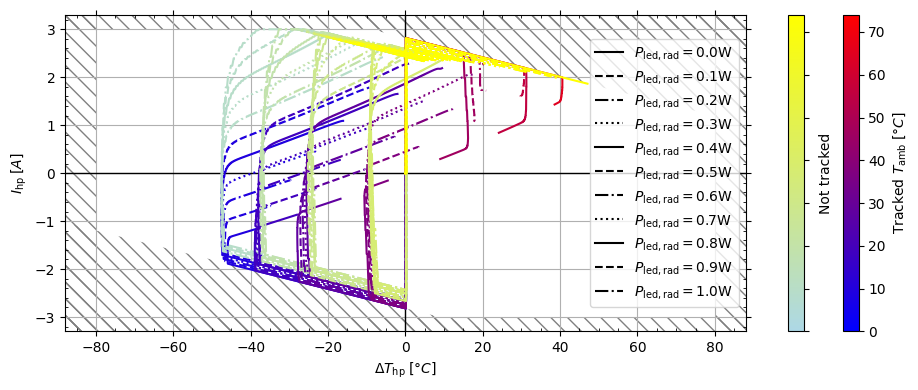

In [30]:
## Colors
# Tracked coloring
temperatures = ["blue", "red"] # ["lightgray", "darkgray"]
cmap_tracked = LinearSegmentedColormap.from_list("temperature_scale", temperatures)
# cmap_tracked = plt.colormaps['cool']

# Not tracked coloring
# grays = ["#D3D3D3", "#696969"] # ["lightgray", "darkgray"]
grays = ["lightblue", "yellow"]
cmap_untracked = LinearSegmentedColormap.from_list("gray_scale", grays)

# T_amb_vec = conv_temp(np.linspace(-70.0, 70.0, num=num_T_amb), 'C', 'K') # K
norm_tracked   = Normalize(vmin=conv_temp(T_amb_vec[0], 'K', 'C'), vmax=conv_temp(T_amb_vec[-1], 'K', 'C'))
norm_untracked = Normalize(vmin=conv_temp(T_amb_vec[0], 'K', 'C'), vmax=conv_temp(T_amb_vec[-1], 'K', 'C'))

# Types of lines
P_rad_lin_style = ["-", "--", "-.", ":"]

sim_len = sim.time_steps


arrow_step = 80

# Voltage constraints
_, _, _ = LEDpar.get_x_from_P_rad(P_rad_vec[0])
model = Model(LEDpar, x0, T_amb0=T_amb)

x_vec = np.linspace(-100, 100, sim_len)
y_vec_min, y_vec_max = model.get_constraints_U_BT2I_HP(x_vec)

### Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(y=0, lw=1, color='black', label='_nolegend_')
ax.axvline(x=0, lw=1, color='black', label='_nolegend_')

# Constraints
x_lim_max = model.DeltaT_max * 1.1
y_lim_max = model.I_HP_max * 1.1

fill_color = 'gray'
fill_alpha = 0.1
hatch_style = '\\\\'

# ax.plot(x_vec, y_vec_max, color='black', label='_nolegend_')
# ax.fill_between(x_vec, y_vec_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# ax.plot(x_vec, y_vec_min, color='black', label='_nolegend_')
# ax.fill_between(x_vec, y_vec_min, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_min, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# ax.axhline(y=model.I_HP_max, color='black', label='_nolegend_')
# ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# ax.axhline(y=-model.I_HP_max, color='black', label='_nolegend_')
# ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# ax.axvline(x=model.DeltaT_max, color='black', label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# ax.axvline(x=-model.DeltaT_max, color='black', label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# Lines for legend
for i, P_rad in enumerate(P_rad_vec):
    ax.plot([], [], linestyle=P_rad_lin_style[i % len(P_rad_lin_style)], color='black', label=r'$P_\mathrm{led,rad} = $' + f'{P_rad:.1f}W')

# Group by id_sim
for sim_id, group in all_results_df.groupby(level='id_sim'):
    # Compute x and y values for this trajectory
    x_sim = group["T_bot"].to_numpy() - group["T_top"].to_numpy()
    y_sim = group["I_HP"].to_numpy()

    # Line style based on P_rad
    line_style = P_rad_lin_style[group.index.get_level_values('P_rad_iter')[0] % len(P_rad_lin_style)]

    # Colormap based on tracking
    cmap = cmap_tracked if group["tracked"].iloc[0] else cmap_untracked

    # Entry of the colormap depending on T_amb
    T_amb_i = group.index.get_level_values('T_amb_iter')[0]
    frac_color = (T_amb_i + 1) / num_T_amb
    traj_color = cmap(frac_color)

    ax.plot(x_sim, y_sim, linestyle=line_style, color=traj_color, label='_nolegend_')

    # for i in range(0, len(x_sim) - arrow_step, arrow_step):
    #     ax.arrow(
    #         x_sim[i], y_sim[i], 
    #         x_sim[i + 1] - x_sim[i], y_sim[i + 1] - y_sim[i], 
    #         head_width=0.2, head_length=2.5, fc=traj_color, ec=traj_color, alpha=0.3
    #     )

# Add the colorbars
cbar_tracked = fig.colorbar(plt.cm.ScalarMappable(norm=norm_tracked, cmap=cmap_tracked), ax=ax, location='right', pad=-0.08)
cbar_tracked.set_label(r'Tracked $T_\mathrm{amb} \; [°C]$')

cbar_untracked = fig.colorbar(plt.cm.ScalarMappable(norm=norm_untracked, cmap=cmap_untracked), ax=ax, location='right')
cbar_untracked.ax.set_yticklabels([])
cbar_untracked.set_label(r'Not tracked')

ax.set_xlim(-model.DeltaT_max * 1.1, model.DeltaT_max * 1.1)
ax.set_ylim(-model.I_HP_max * 1.1, model.I_HP_max * 1.1)
ax.set_xlabel(r'$\Delta T_\mathrm{hp} \; [°C]$')
ax.set_ylabel(r'$I_\mathrm{hp} \; [A]$')
# ax.set_title('Current-Temperature Phase Space')
ax.legend()
ax.grid()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='x', which='minor', direction='in', top=True)
ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)
ax.tick_params(axis='x', which='major', top=True)
ax.tick_params(axis='y', which='major', left=True, right=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tight_layout()

if save_traj_plot:
    # Generate filename dynamically
    filename = f"traj_{filename_pid}" if chosen_controller == 'PID' else f"traj_{filename_lqr}"
    save_plot2pdf(filename, fig)
plt.show()

In [15]:
# import phaseportrait as pp
# # Continuous Open-Loop
# # Nonlinear phase portrait
# def f_nonlinear(Tc, Th):
#     u = model.get_operational_input
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = model.dynamics_f(x, u)
#     return x_[1], x_[2]

# # Linear phase portrait
# def f_linear(Tc, Th):
#     u = model.get_operational_input
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = A @ x + B @ u + h
#     return x_[1], x_[2]

# # Closed-Loop
# # Linear phase portrait
# def f_linear_cl(Tc, Th):
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = (A - B @ lqr_controller.K) @ x + h
#     return x_[1], x_[2]

# # Plot
# # Nonlinear Phase Portrait
# pp_nonlinear_op = pp.PhasePortrait2D(f_nonlinear, [-50, 50], Title='Continuous Nonlinear Open-Loop', xlabel=r"$T_top$", ylabel=r"$T_bot$")
# pp_nonlinear_op.plot()

# # Linear Phase Portrait
# pp_linear_op = pp.PhasePortrait2D(f_linear, [-50, 50], Title='Continuous Linear Open-Loop', xlabel=r"$T_top$", ylabel=r"$T_bot$")
# pp_linear_op.plot()

# # Linear Phase Portrait closed-loop
# pp_linear_cl = pp.PhasePortrait2D(f_linear_cl, [100, 300], Title='Continuous Linear Closed-Loop', xlabel=r"$T_top$", ylabel=r"$T_bot$")
# pp_linear_cl.plot()

In [16]:
# x_FAN = 1.0
# x_SoC = 0.85
# I_HP = 1.2

# lenght_data = 10

# # Define the system of equations dTh/dt = f3(Th, Tc) and dTc/dt = f2(Th, Tc)
# def f3(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
#     tmp = np.zeros_like(Th)

#     for i in range(lenght_data):
#         tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[2]

#     return tmp

# def f2(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
#     tmp = np.zeros_like(Th)

#     for i in range(lenght_data):
#         tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[1]

#     return tmp

# Th_sim = results["T_bot"].to_numpy()
# Tc_sim = results["T_top"].to_numpy()

# # Create a grid of points in the (x, y) plane
# x = np.linspace(Th_sim.min()-abs(Th_sim.min())*0.1, Th_sim.max()+abs(Th_sim.max())*0.1, lenght_data)
# y = np.linspace(Tc_sim.min()-abs(Tc_sim.min())*0.1, Tc_sim.max()+abs(Tc_sim.max())*0.1, lenght_data)
# X, Y = np.meshgrid(x, y)

# # Compute the vector field at each grid point
# u = f3(x, y)
# v = f2(x, y)
# U, V = np.meshgrid(u, v)

# # Plot the streamlines using the quiver function
# plt.figure(figsize=(10, 3))
# plt.quiver(X, Y, U, V, color='g')  # Arrows indicating the direction field
# plt.plot(Th_sim, Tc_sim, color='r')
# plt.plot(conv_temp(T_amb0, 'K', 'C'), conv_temp(T_amb0, 'K', 'C'), 'o', color='black', label='Ambient')
# plt.xlabel(r"$T_\mathrm{h} \; [°C]$")
# plt.ylabel(r"$T_\mathrm{c} \; [°C]$")
# plt.title('Temperature Phase Portrait')

# # Additionally, plot using streamplot for smoother visualization
# plt.streamplot(X, Y, U, V, color='b', linewidth=1)

# plt.grid()
# plt.show()